<a href="https://colab.research.google.com/github/abbyambita/Diagnosing-COVID-from-CT-Scan-Images/blob/main/trial_acgan_git.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [ ]:
import os 

os.chdir("/content/gdrive/My Drive")

!ls  '/content/gdrive/My Drive/CS 284 Mini-Project/Code/output_result/acgan/git'

%cd "/content/gdrive/My Drive/CS 284 Mini-Project/Code/"

'batch=16_lr=0.0001_epochs=600'  'batch=32_lr=0.002_epochs=600'
'batch=16_lr=0.001_epochs=600'	 'batch=32_lr=0.01_epochs=600'
'batch=16_lr=0.002_epochs=600'	 'batch=64_lr=0.0001_epochs=600'
'batch=16_lr=0.01_epochs=600'	 'batch=64_lr=0.001_epochs=600'
'batch=32_lr=0.0001_epochs=600'  'batch=64_lr=0.002_epochs=600'
'batch=32_lr=0.001_epochs=600'	 'batch=64_lr=0.01_epochs=600'
/content/gdrive/.shortcut-targets-by-id/1eVFVz23F6ROX0s10Oe3tT9HVzr502iW2/CS 284 Mini-Project/Code


In [ ]:
from __future__ import print_function
#%matplotlib inline
import argparse
import os
import PIL
import glob
import xml.etree.ElementTree as ET
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import seaborn as sns
from IPython.display import HTML
from torchvision.utils import save_image
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau, CosineAnnealingLR
from tqdm import tqdm_notebook as tqdm
from IPython.display import clear_output
from scipy.stats import truncnorm
%matplotlib inline
plt.rcParams['image.interpolation'] = 'nearest'

In [ ]:
# data_dir = 'revised-git'
# image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
#                                           data_transforms[x])
#                   for x in ['train', 'val', 'test']}

# dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=32,
#                                              shuffle=True, num_workers=4)
#               for x in ['train', 'val', 'test']}

In [ ]:
# Setting parameters
workers = 4
batch_size = 64
image_size = 64
nc = 3
nz = 128
ngf = 64
ndf = 64
#num_epochs = 300
#num_epochs = 600
#lr = 0.001
beta1 = 0.5
ngpu = 1
num_show = 6
n_class = 2
outf = 'output_result/acgan_resized'
if not os.path.exists(outf):
    os.mkdir(outf)

# workers = 4
# batch_size = 32
# image_size = 224
# nc = 3
# nz = 128
# ngf = 224
# ndf = 224
# #num_epochs = 300
# #num_epochs = 600
# #lr = 0.001
# beta1 = 0.5
# ngpu = 1
# num_show = 6
# n_class = 2
# outf = 'output_result/acgan-resized'
# if not os.path.exists(outf):
#     os.mkdir(outf)

device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")
print(device)

cuda:0


In [ ]:
def load_images(batch_size):
  dataroot = "revised-git/train"

  dataset = dset.ImageFolder(root=dataroot,
                            transform=transforms.Compose([
                                transforms.Resize(image_size),
                                transforms.RandomHorizontalFlip(),
                                transforms.CenterCrop(image_size),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                            ]))
  
  print(len(dataset))

  dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,shuffle=True, num_workers=workers)

  return dataloader

425


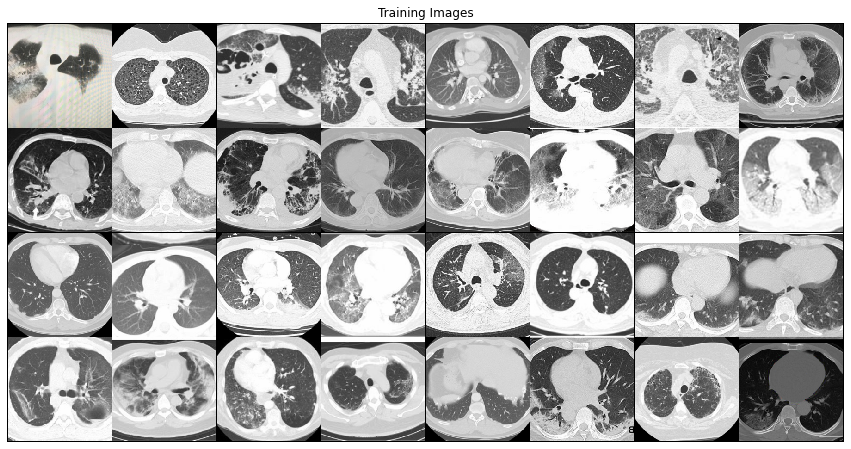

In [ ]:
dataloader = load_images(32)
real_batch = iter(dataloader).next()
plt.figure(figsize=(15,15))
plt.axis("off")
plt.title("Training Images")
image = np.transpose(vutils.make_grid(real_batch[0].to(device), normalize=True).cpu(),axes=(1,2,0))
plt.imshow(image)

In [ ]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [ ]:
class Generator(nn.Module):

    def __init__(self, ngpu, nz=nz, ngf=ngf, nc=nc, n_class=n_class):

        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.ReLU = nn.ReLU(True)
        self.Tanh = nn.Tanh()
        self.conv1 = nn.ConvTranspose2d(nz+n_class, ngf * 8, 4, 1, 0, bias=False)
        self.BatchNorm1 = nn.BatchNorm2d(ngf * 8)

        self.conv2 = nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False)
        self.BatchNorm2 = nn.BatchNorm2d(ngf * 4)

        self.conv3 = nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False)
        self.BatchNorm3 = nn.BatchNorm2d(ngf * 2)

        self.conv4 = nn.ConvTranspose2d(ngf * 2, ngf * 1, 4, 2, 1, bias=False)
        self.BatchNorm4 = nn.BatchNorm2d(ngf * 1)

        self.conv5 = nn.ConvTranspose2d(ngf * 1, nc, 4, 2, 1, bias=False)

        self.apply(weights_init)


    def forward(self, input):

        x = self.conv1(input)
        x = self.BatchNorm1(x)
        x = self.ReLU(x)

        x = self.conv2(x)
        x = self.BatchNorm2(x)
        x = self.ReLU(x)

        x = self.conv3(x)
        x = self.BatchNorm3(x)
        x = self.ReLU(x)

        x = self.conv4(x)
        x = self.BatchNorm4(x)
        x = self.ReLU(x)

        x = self.conv5(x)
        output = self.Tanh(x)
        return output
netG = Generator(ngpu).to(device)
netG.apply(weights_init)
print(netG)

Generator(
  (ReLU): ReLU(inplace=True)
  (Tanh): Tanh()
  (conv1): ConvTranspose2d(130, 1792, kernel_size=(4, 4), stride=(1, 1), bias=False)
  (BatchNorm1): BatchNorm2d(1792, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): ConvTranspose2d(1792, 896, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (BatchNorm2): BatchNorm2d(896, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): ConvTranspose2d(896, 448, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (BatchNorm3): BatchNorm2d(448, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): ConvTranspose2d(448, 224, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (BatchNorm4): BatchNorm2d(224, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): ConvTranspose2d(224, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
)


In [ ]:
class Discriminator(nn.Module):

    def __init__(self, ngpu, ndf=ndf, nc=nc, n_class=n_class):

        super(Discriminator, self).__init__()
        self.LeakyReLU = nn.LeakyReLU(0.2, inplace=True)
        self.conv1 = nn.Conv2d(nc, ndf, 4, 2, 1, bias=False)
        self.conv2 = nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False)
        self.BatchNorm2 = nn.BatchNorm2d(ndf * 2)
        self.conv3 = nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False)
        self.BatchNorm3 = nn.BatchNorm2d(ndf * 4)
        self.conv4 = nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False)
        self.BatchNorm4 = nn.BatchNorm2d(ndf * 8)
        self.conv5 = nn.Conv2d(ndf * 8, ndf * 1, 4, 1, 0, bias=False)
        self.disc_linear = nn.Linear(ndf * 1, 1)
        self.aux_linear = nn.Linear(ndf * 1, n_class)
        self.softmax = nn.Softmax()
        self.sigmoid = nn.Sigmoid()
        self.ndf = ndf
        self.apply(weights_init)

    def forward(self, input):

        x = self.conv1(input)
        x = self.LeakyReLU(x)

        x = self.conv2(x)
        x = self.BatchNorm2(x)
        x = self.LeakyReLU(x)

        x = self.conv3(x)
        x = self.BatchNorm3(x)
        x = self.LeakyReLU(x)

        x = self.conv4(x)
        x = self.BatchNorm4(x)
        x = self.LeakyReLU(x)

        x = self.conv5(x)
        x = x.view(-1, self.ndf * 1)
        c = self.aux_linear(x)
        c = self.softmax(c)
        s = self.disc_linear(x)
        s = self.sigmoid(s)
        return s,c

netD = Discriminator(ngpu).to(device)
netD.apply(weights_init)
print(netD)

Discriminator(
  (LeakyReLU): LeakyReLU(negative_slope=0.2, inplace=True)
  (conv1): Conv2d(3, 224, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (conv2): Conv2d(224, 448, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (BatchNorm2): BatchNorm2d(448, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(448, 896, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (BatchNorm3): BatchNorm2d(896, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(896, 1792, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (BatchNorm4): BatchNorm2d(1792, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv2d(1792, 224, kernel_size=(4, 4), stride=(1, 1), bias=False)
  (disc_linear): Linear(in_features=224, out_features=1, bias=True)
  (aux_linear): Linear(in_features=224, out_features=2, bias=True)
  (softmax): Softmax(dim=None)
  (sigmoid): Sigmoid()
)


In [ ]:
def truncated_normal(size, threshold=1):
    values = truncnorm.rvs(-threshold, threshold, size=size)
    return values

def show_generated_img_all():
    dog_label = torch.randint(n_class, (64,), dtype=torch.long, device=device)
    noise = torch.randn(64, nz, 1, 1, device=device)
    gen_image = concat_noise_label(noise, dog_label, device)  
    gen_image = netG(gen_image).to("cpu").clone().detach().squeeze(0)
    gen_image = gen_image.numpy().transpose(0, 2, 3, 1)
    # gen_image = gen_image.numpy().transpose(1, 2, 0)
    gen_image = (gen_image + 1.0) / 2.0
    
    fig = plt.figure(figsize=(25, 16))
    for ii, img in enumerate(gen_image):
        ax = fig.add_subplot(8, 8, ii + 1, xticks=[], yticks=[])
        plt.imshow(img)
        

def show_generated_img(num_show):
    gen_images = []
    for _ in range(num_show):
        noise = torch.randn(1, nz, 1, 1, device=device)
        dog_label = torch.randint(0, n_class, (1, ), device=device)
        gen_image = concat_noise_label(noise, dog_label, device)
        gen_image = netG(gen_image).to("cpu").clone().detach().squeeze(0)
        # gen_image = gen_image.numpy().transpose(0, 2, 3, 1)
        gen_image = gen_image.numpy().transpose(1, 2, 0)
        gen_images.append(gen_image)
        
    fig = plt.figure(figsize=(10, 5))
    for i, gen_image in enumerate(gen_images):
        ax = fig.add_subplot(1, num_show, i + 1, xticks=[], yticks=[])
        plt.imshow(gen_image + 1 / 2)
    plt.show()
    
def show_loss(G_losses, D_losses, d, ylim): 
    sns.set_style("white")
    fig = plt.figure(figsize=(10,5))
    ax = fig.add_subplot(1,1,1)
    ax.set_title("Generator and Discriminator Loss During Training")
    ax.plot(G_losses,label="G",c="b")
    ax.plot(D_losses,label="D",c="r")
    ax.set_xlabel("iterations")
    ax.set_ylabel("Loss")
    ax.legend()
    if ylim == True:
        ax.set_ylim(0,4)
    plt.savefig(d+'/lossesv1'+str(ylim)+'.png')

In [ ]:
def mse(imageA, imageB):
    err = np.sum((imageA.astype("float") - imageB.astype("float")) ** 2)
    err /= float(imageA.shape[0] * imageA.shape[1])
    return err

breeds = ['noncovid', 'covid']
def analyse_generated_by_class(n_images):
    good_breeds = []
    for l in range(n_class):
        sample = []
        for _ in range(n_images):
            noise = torch.randn(1, nz, 1, 1, device=device)
            dog_label = l
            noise_label = concat_noise_label(noise, dog_label, device)
            gen_image = netG(noise_label).to("cpu").clone().detach().squeeze(0)
            gen_image = gen_image.numpy().transpose(1, 2, 0)
            sample.append(gen_image)

        d = np.round(np.sum([mse(sample[k], sample[k + 1]) for k in range(len(sample) - 1)]) / n_images, 1,)
        if d < 1.0:
            continue  # had mode colapse(discard)
            
        print(f"Generated breed({d}): ", breeds[l])    
        good_breeds.append(l)
    return good_breeds


def create_submit(good_breeds,num_epochs, batch_size, lr):
    print("Creating submit")
    cov = "acgan_output_images/acgan_resized/git/epochs="+str(num_epochs)+",lr="+str(lr)+",batch_size="+str(batch_size)+"/covid"
    noncov = "acgan_output_images/acgan_resized/git/epochs="+str(num_epochs)+",lr="+str(lr)+",batch_size="+str(batch_size)+"/noncovid"
    os.makedirs(cov, exist_ok=True)
    os.makedirs(noncov, exist_ok=True)
    im_batch_size = 100
    n_images = 10000

    for i_batch in range(0, n_images, im_batch_size):
        z = truncated_normal((im_batch_size, nz, 1, 1), threshold=1)
        noise = torch.from_numpy(z).float().to(device)

        
        dog_label = np.random.choice(good_breeds, size=im_batch_size, replace=True) 
        #print(dog_label)
        dog_label = torch.from_numpy(dog_label).to(device).clone().detach().squeeze(0)
        noise_label = concat_noise_label(noise, dog_label, device)
    
        gen_images = (netG(noise_label) + 1) / 2
        
        for i_image in range(gen_images.size(0)):
            if(breeds[dog_label[i_image]]=="noncovid"):
              save_image(gen_images[i_image, :, :, :], os.path.join(noncov, f'image_{i_batch+i_image:05d}_'+breeds[dog_label[i_image]]+'.png'))
            else:
              save_image(gen_images[i_image, :, :, :], os.path.join(cov, f'image_{i_batch+i_image:05d}_'+breeds[dog_label[i_image]]+'.png'))

    #import shutil
    #shutil.make_archive("images", "zip", "acgan_output_images")

In [ ]:


def onehot_encode(label, device, n_class=n_class):  
    eye = torch.eye(n_class, device=device) 
    return eye[label].view(-1, n_class, 1, 1)   
 
def concat_image_label(image, label, device, n_class=n_class):
    B, C, H, W = image.shape   
    oh_label = onehot_encode(label, device=device)
    oh_label = oh_label.expand(B, n_class, H, W)
    return torch.cat((image, oh_label), dim=1)
 
def concat_noise_label(noise, label, device):
    oh_label = onehot_encode(label, device=device)
    return torch.cat((noise, oh_label), dim=1)



In [ ]:
fixed_noise = torch.randn(1, nz, 1, 1, device=device)
fixed_label = torch.randint(0, n_class, (1, ), device=device)
fixed_noise_label = concat_noise_label(fixed_noise, fixed_label, device)

r_label = 0.7
f_label = 0

# Loss functions
s_criterion = nn.BCELoss()
c_criterion = nn.NLLLoss()

In [ ]:
import time

# Training Loop

def train(dataloader, batch_size, lr, num_epochs):
  d = "output_result/acgan_resized/git/batch="+str(batch_size)+"_lr="+str(lr)+"_epochs="+str(num_epochs)
  os.makedirs(d, exist_ok = True)
  since = time.time()

  # Setup Adam optimizers for both G and D
  optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
  optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))


  input = torch.tensor([batch_size, nc, image_size, image_size], device=device)
  noise = torch.tensor([batch_size, nz, 1, 1], device=device)

  G_losses = []
  D_losses = []

  iters = 0
  for epoch in range(num_epochs):
      for i, data in enumerate(tqdm(dataloader)):
          # prepare real image and label
          real_label = data[1].to(device)
          real_image = data[0].to(device)
          b_size = real_label.size(0)      
          
          # prepare fake image and label
          fake_label = torch.randint(n_class, (b_size,), dtype=torch.long, device=device)
          noise = torch.randn(b_size, nz, 1, 1, device=device).squeeze(0)
          noise = concat_noise_label(noise, real_label, device)  
          fake_image = netG(noise)
          
          # target
          real_target = torch.full((b_size,), r_label, device=device)
          fake_target = torch.full((b_size,), f_label, device=device)
          real_target = real_target.unsqueeze(1)
          fake_target = fake_target.unsqueeze(1)
          real_target = real_target.float()
          fake_target = fake_target.float()
          #-----------------------
          # Update Discriminator
          #-----------------------
          netD.zero_grad()
          
          # train with real
          s_output, c_output = netD(real_image)
          s_errD_real = s_criterion(s_output, real_target)  # realfake

          c_errD_real = c_criterion(c_output, real_label)  # class
          errD_real = s_errD_real + c_errD_real
          errD_real.backward()
          D_x = s_output.data.mean()

          # train with fake
          s_output,c_output = netD(fake_image.detach())
          s_errD_fake = s_criterion(s_output, fake_target)  # realfake
          c_errD_fake = c_criterion(c_output, real_label)  # class
          errD_fake = s_errD_fake + c_errD_fake
          errD_fake.backward()
          D_G_z1 = s_output.data.mean()
          
          errD = s_errD_real + s_errD_fake
          optimizerD.step()        

          #-----------------------
          # Update Generator
          #-----------------------
          netG.zero_grad()
          
          s_output,c_output = netD(fake_image)
          #print(len(s_output))
          s_errG = s_criterion(s_output, real_target)  # realfake
          c_errG = c_criterion(c_output, real_label)  # class
          errG = s_errG + c_errG
          errG.backward()
          D_G_z2 = s_output.data.mean()
          
          optimizerG.step()

          # Save Losses for plotting later
          G_losses.append(errG.item())
          D_losses.append(errD.item())
          
          iters += 1

      # scheduler.step(errD.item())
      if (epoch + 1) % 10 == 0:        
        print('[%d][%.3f][%d/%d][%d/%d]\nLoss_D: %.4f\tLoss_G: %.4f\nD(x): %.4f\tD(G(z)): %.4f / %.4f'
            % (batch_size,lr,epoch+1, num_epochs, i+1, len(dataloader),
              errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))
      
      #show_generated_img(num_show)
  
      # ---------  save model  ----------
      if (epoch + 1) % 20 == 0:  
          # torch.save(netG.state_dict(), '{}/netG_epoch_{}.pth'.format(outf, epoch + 1))
          # torch.save(netD.state_dict(), '{}/netD_epoch_{}.pth'.format(outf, epoch + 1))
          torch.save(netG, '{}/netG_epoch_{}.pth'.format(d, epoch + 1))
          torch.save(netD, '{}/netD_epoch_{}.pth'.format(d, epoch + 1))

          # --------- save fake image  ----------
          fake_image = netG(fixed_noise_label)   
          vutils.save_image(fake_image.detach(), '{}/fake_samples_epoch_{:03d}.png'.format(d, epoch + 1),normalize=True, nrow=5)
          
  time_elapsed = time.time() - since
  print('Training complete in {:.0f}m {:.0f}s'.format(
          time_elapsed // 60, time_elapsed % 60))
  return G_losses, D_losses, d


In [ ]:
import matplotlib.pyplot as plt
plt.ion()

def plot_losses(G_losses,D_losses,d):
  fig = plt.figure()
  plt.plot(G_losses, label='generator')
  plt.plot(D_losses, label='discriminator')
  plt.xlabel('Iterations')
  plt.ylabel('Loss')
  plt.legend()
  plt.savefig(d+'/losses.png')
  plt.show()


In [ ]:
def plot_all(gen_losses,disc_losses,batch_size,d):

  learning_rates = [0.001, 0.002, 0.01,0.0001]

  for i, val in enumerate(gen_losses):
    plt.plot(val, label='GEN Lr '+str(learning_rates[i]))
    plt.legend(frameon=False)

  for i, val in enumerate(disc_losses):
    plt.plot(val, '-x',label='DISC Lr '+str(learning_rates[i]))
    plt.legend(frameon=False)

  plt.xlabel('iterations')
  plt.ylabel('loss')
  plt.title('Loss for Batch Size '+str(batch_size))    
  plt.savefig(d+"/Loss_Batch"+str(batch_size)+".png")
  plt.show()


def generate_images(batch_size,lr,num_epochs):
  cv = 'acgan_output_images/acgan_resized/git/batch_size='+str(batch_size)+"_lr="+str(lr)+"_epochs="+str(num_epochs)+"/covid"
  ncv='acgan_output_images/acgan_resized/git/batch_size='+str(batch_size)+"_lr="+str(lr)+"_epochs="+str(num_epochs)+"/noncovid"

  os.makedirs(cv, exist_ok = True)
  os.makedirs(ncv, exist_ok = True)

  for i in range(n_class):
    for img in range(2000):
      noise = torch.randn(1, nz, 1, 1, device=device)
      dog_label = i
      noise_label = concat_noise_label(noise, dog_label, device)
      gen_image = netG(noise_label)

      if(i==0):
        vutils.save_image(gen_image.detach(), ncv+'/fake_samples_{:03d}.png'.format(img),normalize=True, nrow=5)
      else:
        vutils.save_image(gen_image.detach(), cv+'/fake_samples_{:03d}.png'.format(img),normalize=True, nrow=5)

In [ ]:
import matplotlib.pyplot as plt
plt.ion()

def run():
  batch_sizes = [32, 16, 64]
  learning_rates = [0.001, 0.002, 0.01,0.0001]

  #batch_sizes = [64]
  #learning_rates = [0.002, 0.01]
  num_epochs = 600
  
  #reset models
  netG = Generator(ngpu).to(device)
  netG.apply(weights_init)

  netD = Discriminator(ngpu).to(device)
  netD.apply(weights_init)

  for batch_size in batch_sizes:

    dataloader = load_images(batch_size)

    gen_losses = []
    disc_losses = []

    for lr in learning_rates:
      G_losses, D_losses, d = train(dataloader, batch_size,lr,num_epochs) #train
      gen_losses.append(G_losses)
      disc_losses.append(D_losses)

      show_generated_img(6)
      show_loss(G_losses, D_losses, d, ylim=False)
      show_loss(G_losses, D_losses, d, ylim=True)
      plot_losses(G_losses, D_losses, d)

      generate_images(batch_size,lr,num_epochs)

      # #produce images
      # good_images = analyse_generated_by_class(6)
      # if(len(good_images) != 0):
      #   create_submit(good_images,num_epochs, batch_size, lr)

      # # visualization generate image of all classes 
      # fig = plt.figure(figsize=(20,40))
      # for i in range(n_class):
      #     ax = fig.add_subplot(20,6,i+1)
      #     noise = torch.randn(1, nz, 1, 1, device=device)
      #     dog_label = i
      #     noise_label = concat_noise_label(noise, dog_label, device)
      #     gen_image = netG(noise_label).to("cpu").clone().detach().squeeze(0)
      #     # gen_image = gen_image.numpy().transpose(0, 2, 3, 1)
      #     gen_image = gen_image.numpy().transpose(1, 2, 0)
      #     gen_image = (gen_image + 1.0) / 2.0
      #     ax.axis('off')
      #     ax.set_title(breeds[i])
      #     ax.imshow(gen_image, cmap="gray")
      # plt.tight_layout()
      # plt.show()

    plot_all(gen_losses, disc_losses, batch_size, d)


In [ ]:
run()

425


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:42: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


ValueError: ignored